# Notebook to generate figure 5
experimental parameters for the two datasets:
- Sodium:
   - dataset : October 7th, 2020
   - exposure time: 200 ms
   - time between images : 12 ms
   - number of images in each reference wing: 100
- Potassium:
   - dataset : October 15th, 2020
   - exposure time: 100 ms
   - time between images : 12 ms
   - number of images in each reference wing: 100

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy import stats
from uncertainties import ufloat, unumpy
import os
import pandas as pd
from scipy.stats import poisson

In [2]:
def analyze(file_path, Cam_EXPOT):
    Counts=pd.read_csv(file_path,  encoding='UTF-8')
    Split_Counts=np.array_split(Counts['Counts'],len(Counts['Run_number'].unique()))
    Split_Counts_array=np.array(Split_Counts)
    atom_images = np.size(Split_Counts_array[1])
    time_between_atom_images = 12e-3
    time = np.arange(atom_images)*(time_between_atom_images + Cam_EXPOT)
    return time, Split_Counts_array;

# Sodium Data
Load all 500 time traces and plot them into one figure

In [3]:
PATH4 = os.path.join("data/Oct07_Scan_0000_Cam_EXPOT=0.2.csv")
PATH_fig = os.path.join("figures/")

In [4]:
time, Split_Counts_array4 = analyze(PATH4, Cam_EXPOT=200e-3)

In [5]:
Nruns, Nimg = Split_Counts_array4.shape

In [6]:
Split_Counts_array4 = np.delete(Split_Counts_array4,0,1)
Nruns, Nimg = np.shape(Split_Counts_array4)
atom_images = np.size(Split_Counts_array4[1])
time_between_atom_images = 12e-3
Cam_EXPOT=200e-3
C = 1.1514e4       # Calibration factor extracted from linear fit to calibration data from peak positions in histogram fig. 6
time = np.arange(atom_images)*(time_between_atom_images + Cam_EXPOT)

## Plot the loading for sodium together with the average and error band

In [7]:
Avg_Counts4=np.mean(Split_Counts_array4, axis=0)
Std_Counts4=Split_Counts_array4.std(axis=0)

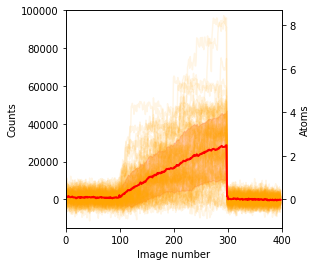

In [8]:
img = time/(time_between_atom_images + Cam_EXPOT)

fig = plt.figure(figsize=(4.5,4)) 
ax2 = fig.add_subplot(1, 1, 1)
ax2.plot(img, Split_Counts_array4.T, color =  'orange', alpha = 0.1);
ax2.plot(img, Avg_Counts4, color = 'red', alpha = 1, linewidth = 2);
ax2.fill_between(img,Avg_Counts4-Std_Counts4, Avg_Counts4+Std_Counts4 ,color = 'red', alpha = 0.18, zorder=2)
ax2.set_xlim(0,400)
ax2.set_ylim(-1.5e4,10e4)
ax2.set_ylabel('Counts')
ax2.set_xlabel('Image number')
ax1 = ax2.twinx()  
ax1.set_ylim(-1.5e4/C,10e4/C) # second y-axis with atom number using calibration factor C: Nat = Nc/C
ax1.set_ylabel('Atoms')
fig.tight_layout()
fig.subplots_adjust(top=0.9);
my_file = 'Figure5_A1.pdf'
fig.savefig(os.path.join(PATH_fig, my_file)) 

## Do Bootstrapping for data

In [9]:
Nbootstrap = 500;

means4 = np.zeros((Nbootstrap, Nimg))
stds4 = np.zeros((Nbootstrap, Nimg))
for jj in np.arange(Nbootstrap):
    X = np.zeros(Split_Counts_array4.shape)
    rand_runs = np.random.randint(Nruns, size=(Nruns))
    for ii in np.arange(Nruns):
        X[ii,:] = Split_Counts_array4[rand_runs[ii], :]
    means4[jj,:] = np.mean(X, axis=0)
    stds4[jj,:] = X.std(axis=0)

In [10]:
means_mean4 = np.mean(means4, axis=0)
var_mean4 = np.mean(stds4**2, axis=0)
var_std4 = np.std(stds4**2, axis=0)#/np.sqrt(Nbootstrap)

## Calculate/ Plot variance as function of mean counts for sodium

In [11]:
var_l, var_u = np.percentile(stds4**2, [16, 84], axis=0);

In [12]:
inds=np.argsort(means_mean4)
x = np.linspace(-5e2,3.5e4,50)

In [13]:
C = 1.1514e4       # Calibration factor extracted from linear fit to calibration data from peak positions in histogram fig. 6
sigma_d = 2.201e3  

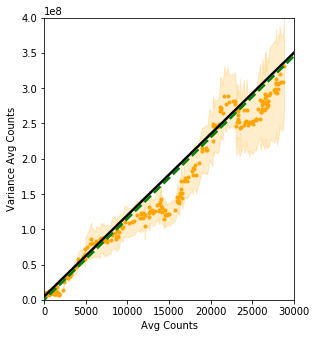

In [14]:
fig = plt.figure(figsize=(4.5,5)) 
ax2 = fig.add_subplot(1, 1, 1)
ax2.fill_between(means_mean4[inds], var_l[inds], var_u[inds],color = 'orange', alpha = 0.2)
ax2.plot(means_mean4,var_mean4, '.', color = 'orange')
ax2.plot(x, C*x+sigma_d**2, 'k', zorder=2,  linewidth=2.5)
ax2.plot(x, C*x, 'g--', zorder=3, linewidth=2.5)
ax2.set_ylabel('Variance Avg Counts')
ax2.set_ylim([0,4e8])
ax2.set_xlim(0, 3e4)
ax2.set_xlabel('Avg Counts')
fig.tight_layout()
fig.subplots_adjust(top=0.9);
my_file = 'Figure5_B1.pdf'
fig.savefig(os.path.join(PATH_fig, my_file)) 

Inset for small average counts

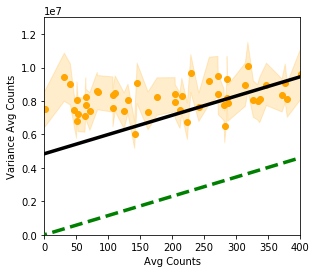

In [15]:
fig = plt.figure(figsize=(4.5,4)) 
ax1 = fig.add_subplot(1, 1, 1)
ax1.fill_between(means_mean4[inds], var_l[inds], var_u[inds],color = 'orange', alpha = 0.2)
ax1.plot(means_mean4,var_mean4, 'o', color = 'orange')
ax1.plot(x, C*x+sigma_d**2, 'k-', zorder=3, linewidth=3.5)
ax1.plot(x, C*x, 'g--', zorder=3, linewidth=3.5)
ax1.set_ylim([0,1.3e7])
ax1.set_xlim(0, 4e2)
ax1.set_ylabel('Variance Avg Counts')
ax1.set_xlabel('Avg Counts')
fig.tight_layout()
fig.subplots_adjust(top=0.9);
my_file = 'Figure5_B1_inset.pdf'
fig.savefig(os.path.join(PATH_fig, my_file)) 

# Potassium Data

In [16]:
PATH = os.path.join("data/Oct15_K_Scan_0009_KtwoDInt=1.4.csv")
PATH_fig = os.path.join("figures/")

In [17]:
time, Split_Counts_array = analyze(PATH, Cam_EXPOT=100e-3)

## Plot the loading for potassium together with the average and error band

In [18]:
Avg_Counts_K=np.mean(Split_Counts_array, axis=0)
Std_Counts_K=Split_Counts_array.std(axis=0)

In [19]:
Nruns, Nimg = Split_Counts_array.shape

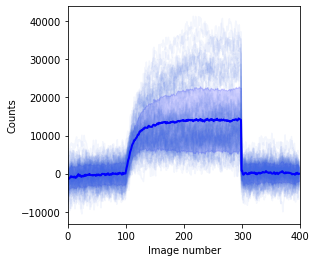

In [20]:
Cam_EXPOT=100e-3
img = time/(12e-3 + Cam_EXPOT)
fig = plt.figure(figsize=(4.5,4)) 
ax2 = fig.add_subplot(1, 1, 1)
ax2.plot(img, Split_Counts_array.T, color =  'royalblue', alpha = 0.06);
ax2.plot(img, Avg_Counts_K, color = 'blue', alpha = 1, linewidth = 2);
ax2.fill_between(img,Avg_Counts_K-Std_Counts_K, Avg_Counts_K+Std_Counts_K ,color = 'blue', alpha = 0.18, zorder=2)
ax2.set_xlim(0,400)
ax2.set_ylabel('Counts')
ax2.set_xlabel('Image number')
fig.tight_layout()
fig.subplots_adjust(top=0.9);
#my_file = 'Figure5_A2.pdf'
#fig.savefig(os.path.join(PATH_fig, my_file)) 

## Extract varying load and loss coefficients to quantify technical noise

In [21]:
Split_Counts_array_atoms = Split_Counts_array[:,100:298]

In [22]:
Nruns, Nimg_atom = Split_Counts_array_atoms.shape

In [23]:
def loading(t,factor,p_loss):
    return (factor/p_loss)*(1-np.exp(-t*p_loss))

In [24]:
factor_array=np.zeros(Nruns)
loss_array=np.zeros(Nruns)
correlation_array=np.zeros(Nruns)

In [25]:
for i in range(Nruns):
    coeff,cov=curve_fit(loading, np.arange(Nimg_atom), Split_Counts_array_atoms[i],bounds=([0.0, 0.0], [0.8*(10**4), 1.0]))
    factor_array[i]=coeff[0]
    loss_array[i]=coeff[1]
    correlation_array[i]=cov[0][1]/np.sqrt(cov[0][0]*(cov[1][1]))

In [26]:
pre_factor=(factor_array/loss_array)
traces=pre_factor[:,None]*(1-np.exp(-np.arange(Nimg_atom)*loss_array[:,None]))

## Perform bootstrapping

In [27]:
std=np.std(traces, axis=0)
avg=np.mean(traces, axis=0)

std_data=np.std(Split_Counts_array, axis=0)
avg_data=np.mean(Split_Counts_array, axis=0)

In [28]:
Nbootstrap = 10000;

means = np.zeros((Nbootstrap, Nimg))
stds = np.zeros((Nbootstrap, Nimg))
for jj in np.arange(Nbootstrap):
    X = np.zeros(Split_Counts_array.shape)
    rand_runs = np.random.randint(Nruns, size=(Nruns))
    for ii in np.arange(Nruns):
        X[ii,:] = Split_Counts_array[rand_runs[ii], :]
    means[jj,:] = np.mean(X, axis=0)
    stds[jj,:] = X.std(axis=0)

In [29]:
means_mean = np.mean(means, axis=0)
var_mean = np.mean(stds**2, axis=0)
var_std = np.std(stds**2, axis=0)

We only want to look at the data in the MOT loading regime

In [30]:
means_mean_less=means_mean[100:299]
var_mean_less=var_mean[100:299]
var_std_less=var_std[100:299]

## Extract calibration and detection noise from linear increase in the low counts regime

In [31]:
indices = []
cutoff = 8e3
for ii in range(len(means_mean_less)):
    if means_mean_less[ii]<=cutoff:
        indices.append(ii)

In [32]:
def lin(x, m, b):
    return m*x+b;

In [33]:
coeff,cov=curve_fit(lin,means_mean_less[indices], var_mean_less[indices], sigma = var_std_less[indices], absolute_sigma=True)

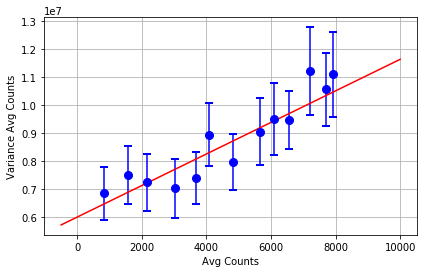

In [34]:
x = np.linspace(-5e2,10e3,100)
fig2, ax2 = plt.subplots()
ax2.errorbar(means_mean_less[indices],y=var_mean_less[indices],yerr=var_std_less[indices],color='blue',fmt='o',markersize=8, linewidth=10, elinewidth=1.5,capsize=4, capthick=2);
ax2.plot(x, lin(x, *coeff), color ='red')
ax2.set_ylabel('Variance Avg Counts')
ax2.set_xlabel('Avg Counts')
ax2.grid()
fig2.tight_layout()
fig2.subplots_adjust(top=0.9);

In [35]:
delta_bg_squared_val = coeff[1]
delta_bg_squared_err = np.sqrt(np.diag(cov)[1])
delta_bg_squared = ufloat(delta_bg_squared_val, delta_bg_squared_err)
delta_bg = unumpy.sqrt(delta_bg_squared)

cal_val = coeff[0]
cal_err = np.sqrt(np.diag(cov)[0])
cal = ufloat(cal_val, cal_err)

atomic_res = delta_bg/cal

In [36]:
print('Background Noise: {:.3ue}' .format(delta_bg))
print('Calibration C: {:.3ue}' .format(cal))
print('Atomic resolution: {:.3ue}' .format(atomic_res))

Background Noise: (2.453+/-0.135)e+03
Calibration C: (5.62+/-1.40)e+02
Atomic resolution: (4.36+/-1.11)e+00


## Plot variance as function of mean counts for sodium

In [37]:
var_l, var_u = np.percentile(stds**2, [16, 84], axis=0);

In [38]:
inds=np.argsort(means_mean)
x = np.linspace(-5e2,6e4,100)

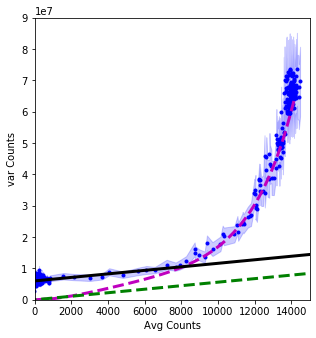

In [39]:
fig = plt.figure(figsize=(4.5,5)) 
ax2 = fig.add_subplot(1, 1, 1)
ax2.fill_between(means_mean[inds], var_l[inds], var_u[inds],color = 'blue', alpha = 0.2)
ax2.plot(means_mean,var_mean,'.', color = 'blue')
ax2.plot(avg,std**2,'m--', linewidth=3)
ax2.plot(x,lin(x, *coeff),'k-',linewidth=3)
ax2.plot(x,lin(x, *coeff)-coeff[1],'g--',linewidth=3)
ax2.set_xlim(0,1.5e4)
ax2.set_ylim(0, 0.9e8)
ax2.set_xlabel('Avg Counts')
ax2.set_ylabel('var Counts')
fig.tight_layout()
fig.subplots_adjust(top=0.9);
my_file = 'Figure5_B2.pdf'
fig.savefig(os.path.join(PATH_fig, my_file)) 

## Re-Plot time traces with calibration

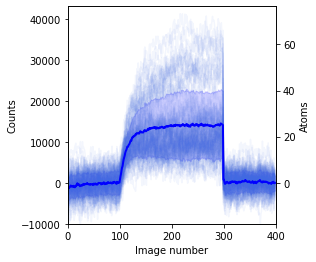

In [40]:
Cam_EXPOT=100e-3
img = time/(12e-3 + Cam_EXPOT)
fig = plt.figure(figsize=(4.5,4)) 
ax2 = fig.add_subplot(1, 1, 1)
ax2.plot(img, Split_Counts_array.T, color =  'royalblue', alpha = 0.06);
ax2.plot(img, Avg_Counts_K, color = 'blue', alpha = 1, linewidth = 2);
ax2.fill_between(img,Avg_Counts_K-Std_Counts_K, Avg_Counts_K+Std_Counts_K ,color = 'blue', alpha = 0.18, zorder=2)
ax2.set_xlim(0,400)
ax2.set_ylim(-1e4,4.3e4)
ax2.set_ylabel('Counts')
ax2.set_xlabel('Image number')
ax1 = ax2.twinx()  # instantiate a second axes that shares the same y-axis
ax1.set_ylim(-1e4/cal_val,4.3e4/cal_val)
ax1.set_ylabel('Atoms')
fig.tight_layout()
fig.subplots_adjust(top=0.9);
my_file = 'Figure5_A2.pdf'
fig.savefig(os.path.join(PATH_fig, my_file)) 